# Vortex Panel Method - Airfoils

This code is intended to calculate the effect of general airfoils by using the vortex panel method (VPM) using both constant and linearly varying vortex strengths on each panel.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import path
from scipy.interpolate import interp1d
from sklearn import linear_model

### Creating the Airfoil

In [2]:
# Input data
airfoil_check = True  # var to check airfoil panels
airfoil_type  = 1      # 1: NACA 4 digits, 2: NACA 5 digits, 3: from excel
plot_stream   = True   # whether to plot stream lines around the airfoil
aero_center   = 1      # optimization to calculate the aerodynamic center

# Airfoil data
airfoil_name  = '0012'    # airfoil nomenclature
spacing       = 'cosine'  # 1: 'linear' or 'cosine' as a spacing type
N             = 100        # number of boundary points, N panels = N - 1
blunt_TE      = False     # whether the TE is blunt (True) or sharp (False)

In [3]:
# Run conditions
AoA_init  = 0.0
AoA_final = 10.0
AoA_delta = 1
if AoA_init != AoA_final:
    AoA       = np.arange(AoA_init, AoA_final, AoA_delta)
else:
    AoA = [AoA_init]
U_inf     = 1.0   # Uniform flow velocity
print(AoA)

[0. 1. 2. 3. 4. 5. 6. 7. 8. 9.]


### NACA 4-digits

$y_{c} =
\begin{cases}
\frac{m}{p^2} (2px - x^2), & 0 \leq x < p\\
\frac{m}{(1-p)^2} ((1-2p) + 2px - x^2), & p \leq x \leq 1
\end{cases}
$

where <br>
$m$ is the maximum camber (100 $m$ is the first of of the four digits), <br>
$p$ is the location of maximum camber (10 $p$ is the second digit in the NACA xxxx description). <br>
For example, a NACA 2412 airfoil uses 2% camber (first digit), 40% along the chord and a 0012 symmetrical airfoil having a thickness 12% (third and fourth digits) of the chord. <br>
For this cambered airfoil, because the thickness needs to be applied perpendicular to the camber line, the coordinates $(xu, yu)$ and $(xl, yl)$ of respectively the upper and lower airfoil surface, become <br>

$x_{U} = x - y_{t} \sin \theta, \quad y_{U} = y_{c} + y_{t} \cos \theta \\
x_{L} = x + y_{t} \sin \theta, \quad y_{L} = y_{c} - y_{t} \cos \theta,$

where <br>
$\theta = \arctan \frac{dy_{c}}{dx},\\
\frac{dy_{c}}{dx} = 
\begin{cases}
\frac{2m}{p^2} (p-x), & 0 \leq x \leq p \\
\frac{2m}{(1-p)^2} (p-x), & p \leq x \leq 1
\end{cases} \\
y_{t} = 5t[0.2969 \sqrt{x} - 0.1260x - 0.3516x^2 + 0.2843x^3 - 0.1015x^4]
$


In [4]:
def naca4(name, N, spacing, blunt_TE):
    """
    Calculates a NACA 4-digit airfoil coordinate
        name    : airfoil name based on the 4-digit nomenclature
        N       : number of grid points
        spacing : either 'linear' or 'cosine'
        blunt_TE: whether the TE is blunt (True) or sharp (False)
    """
    N = int(N/2)
    # NACA 4-digit
    m = eval(name[0])  # camber
    p = eval(name[1])  # position of max camber
    t = eval(name[2:]) # thickness
    
    # Constants of NACA 4-digit
    a0 = 0.2969
    a1 = -0.1260
    a2 = -0.3516
    a3 = 0.2843
    if blunt_TE:
        a4 = -0.1015 # blunt TE
    else:
        a4 = -0.1036 # sharp TE
    
    # Airfoil creation
    # percentage
    M = m/100
    P = p/10
    T = t/100
    
    # Airfoil grid
    if spacing == 'linear':
        x = np.linspace(0,1,N)
    elif spacing == 'cosine':
        bet = np.linspace(0,np.pi,N)
        x = 0.5*(1-np.cos(bet))
    
    # Camber and gradient
    yc    = np.zeros(N)
    dyc   = np.zeros(N)
    theta = np.zeros(N)
    
    for i in range(N):
        if x[i] >= 0 and x[i] < P:
            yc[i]  = (M/(P*P))*(2*P*x[i] - x[i]*x[i])
            dyc[i] = (2*M/(P*P))*(P - x[i]) 
        elif x[i] >= P and x[i] <= 1:
            yc[i]  = (M/(1-P)**2)*((1-2*P) + 2*P*x[i] - x[i]*x[i])
            dyc[i] = (2*M/(1-P)**2)*(P - x[i])
        theta[i] = np.arctan(dyc[i])
    
    # Thickness distribution
    yt = np.zeros(N)
    for i in range(N):
        yt[i] = 5*T*(a0*np.sqrt(x[i]) + a1*x[i] + a2*x[i]**2 + a3*x[i]**3 + a4*x[i]**4)

    # Upper surface points
    xu = np.zeros((N,1))
    yu = np.zeros((N,1))
    for i in range(N):
        xu[i,0] = x[i]  - yt[i] * np.sin(theta[i])
        yu[i,0] = yc[i] + yt[i] * np.cos(theta[i])
        
    # Lower surface points
    xl = np.zeros((N,1))
    yl = np.zeros((N,1))
    for i in range(N):
        xl[i,0] = x[i]  + yt[i] * np.sin(theta[i])
        yl[i,0] = yc[i] - yt[i] * np.cos(theta[i])
    
    return xu, xl, yu, yl

### NACA 5-digit airfoils

The NACA 5-digit airfoils use the same thickness envelope as the 4-series but with a different camber line and numbering system. <br><br>
<center><strong>NACA LPQXX</strong>
<br>
e.g.,<br>
<strong>NACA 23012</strong></center>
<table>
    <thead>
        <tr>
            <th style="text-align: left"> Digits </th>
            <th style="text-align: left"> Letter </th>
            <th style="text-align: left"> Example </th>
            <th style="text-align: left"> Description </th>
        </tr>
    </thead>
    <tbody>
        <tr>
            <td style="text-align: center"> 1 </td>
            <td style="text-align: center"> L </td>
            <td style="text-align: center"> 2 </td>
            <td style="text-align: left"> This digit controls the camber. It indicates the designed coefficient of lift (Cl) multiplied by 3/20. In the example, $L = 2$, so $C_{L} = 0.3$</td>
        </tr>
        <tr>
            <td style="text-align: center"> 2 </td>
            <td style="text-align: center"> P </td>
            <td style="text-align: center"> 3 </td>
            <td style="text-align: left"> The position of maximum camber divided by 20. In the example, $P=3$, so maximum camber is at 0.15 or 15% chord. </td>
        </tr>
        <tr>
            <td style="text-align: center"> 3 </td>
            <td style="text-align: center"> Q </td>
            <td style="text-align: center"> 0 </td>
            <td style="text-align: left"> 0 = normal camber line, 1 = reflex camber line </td>
        </tr>
        <tr>
            <td style="text-align: center"> 4 & 5</td>
            <td style="text-align: center"> XX </td>
            <td style="text-align: center"> 12 </td>
            <td style="text-align: left"> The maximum thickness as percentage. In the example, $XX = 12$, so the maximum thickness is 0.12 or 12% chord.</td>
        </tr>
    </tbody>
</table>

The equation for the camber line is split into two sections like the 4 digit series but the division between the two sections is not at the point of maximum camber. There are also different equations for standard and reflex camber lines.

<table>
    <tr>
        <th style="text-align: left; width:10%">  </th>
        <th style="text-align: left; width:30%"> Front $(0 \leq x < r)$</th>
        <th style="text-align: left"> Back $(r \leq x \leq 1)$ </th>
    </tr>
    <tr>
        <td style="text-align: center"> Camber (standard) </td>
        <td style="text-align: left"> $y_{c} = \frac{k_{1}}{6}\big(x^3 - 3rx^2 + r^2(3-r)x\big)$ </td>
        <td style="text-align: left"> $y_{c} = \frac{k_{1}r^3}{6}(1-x)$ </td>
    </tr>
    <tr>
        <td style="text-align: center"> Gradient (standard) </td>
        <td style="text-align: left"> $y_{c} = \frac{dy_{c}}{dx} = \frac{k_{1}}{6} \big(3x^2 - 6rx + r^2(3-r)\big)$ </td>
        <td style="text-align: left"> $\frac{dy_{c}}{dx} = \frac{-k_{1}r^3}{6}$ </td>
    </tr>
    <tr>
        <td style="text-align: center"> Camber (reflex) </td>
        <td style="text-align: left"> $y_{c} = \frac{k_{1}}{6}\big((x-r)^3 - \frac{k_{2}}{k_{1}}(1-r)^3x - r^3x + r^3\big)$ </td>
        <td style="text-align: left"> $y_{c} = \frac{k_{1}}{6}\big(\frac{k_{2}}{k_{1}}(x-r)^3 - \frac{k_{2}}{k_{1}}(1-r)^3x - r^3x + r^3\big)$ </td>
    </tr>
    <tr>
        <td style="text-align: center"> Gradient (reflex) </td>
        <td style="text-align: left"> $y_{c} = \frac{dy_{c}}{dx} = \frac{k_{1}}{6} \big(3(x-r)^2 -\frac{k_{2}}{k_{1}}(1-r)^3 - r^3\big)$ </td>
        <td style="text-align: left"> $\frac{dy_{c}}{dx} = \frac{k_{1}}{6} \big(3\frac{k_{2}}{k_{1}}(x-r)^2 - \frac{k_{2}}{k_{1}}(1-r)^3 - r^3 \big)$ </td>
    </tr>
</table>
<br>
The values for the constants $r$, $k_{1}$, and $k_{2}/k_{1}$ are tabulated for various positions of the maximum camber at a coefficient of lift ($C_{L}$) value of 0.3. The camber and gradient can be scaled linearly to the required $C_{L}$ value.
<table>
    <thead>
        <tr>
            <th style="text-align: center"> Description </th>
            <th style="text-align: center"> Digits </th>
            <th style="text-align: center"> Camber position (%) </th>
            <th style="text-align: center"> $r$ </th>
            <th style="text-align: center"> $k_{1} $ </th>
            <th style="text-align: center"> $k_{2}/k_{1}$ </th>
        </tr>
    </thead>
    <tbody>
        <tr>
            <td style="text-align: center"> 5% standard </td>
            <td style="text-align: center"> 10 </td>
            <td style="text-align: center"> 5 </td>
            <td style="text-align: center"> 0.0580 </td>
            <td style="text-align: center"> 361.400 </td>
            <td style="text-align: center">  </td>
        </tr>
        <tr>
            <td style="text-align: center"> 10% standard </td>
            <td style="text-align: center"> 20 </td>
            <td style="text-align: center"> 10 </td>
            <td style="text-align: center"> 0.1260 </td>
            <td style="text-align: center"> 51.640 </td>
            <td style="text-align: center">  </td>
        </tr>
        <tr>
            <td style="text-align: center"> 15% standard </td>
            <td style="text-align: center"> 30 </td>
            <td style="text-align: center"> 15 </td>
            <td style="text-align: center"> 0.2025 </td>
            <td style="text-align: center"> 15.957 </td>
            <td style="text-align: center">  </td>
        </tr>
        <tr>
            <td style="text-align: center"> 20% standard </td>
            <td style="text-align: center"> 40 </td>
            <td style="text-align: center"> 20 </td>
            <td style="text-align: center"> 0.2900 </td>
            <td style="text-align: center"> 6.643 </td>
            <td style="text-align: center">  </td>
        </tr>
        <tr>
            <td style="text-align: center"> 25% standard </td>
            <td style="text-align: center"> 50 </td>
            <td style="text-align: center"> 25 </td>
            <td style="text-align: center"> 0.3910 </td>
            <td style="text-align: center"> 3.230 </td>
            <td style="text-align: center">  </td>
        </tr>
        <tr>
            <td style="text-align: center"> 10% reflex </td>
            <td style="text-align: center"> 21 </td>
            <td style="text-align: center"> 10 </td>
            <td style="text-align: center"> 0.1300 </td>
            <td style="text-align: center"> 51.990 </td>
            <td style="text-align: center"> 0.000764 </td>
        </tr>
        <tr>
            <td style="text-align: center"> 15% reflex </td>
            <td style="text-align: center"> 31 </td>
            <td style="text-align: center"> 15 </td>
            <td style="text-align: center"> 0.2170 </td>
            <td style="text-align: center"> 15.793 </td>
            <td style="text-align: center"> 0.00677 </td>
        </tr>
        <tr>
            <td style="text-align: center"> 20% reflex </td>
            <td style="text-align: center"> 41 </td>
            <td style="text-align: center"> 20 </td>
            <td style="text-align: center"> 0.3180 </td>
            <td style="text-align: center"> 6.520 </td>
            <td style="text-align: center"> 0.0303 </td>
        </tr>
        <tr>
            <td style="text-align: center"> 25% reflex </td>
            <td style="text-align: center"> 51 </td>
            <td style="text-align: center"> 25 </td>
            <td style="text-align: center"> 0.4410 </td>
            <td style="text-align: center"> 3.191 </td>
            <td style="text-align: center"> 0.1355 </td>
        </tr>
    </tbody>
</table>
<br>
Having calculated the camber line, the thickness distribution, calculation of the airfoil envelope and plotting of coordinates is done in the same way as the NACA 4-digit airfoils. Details can be found in <a href="http://www.dept.aoe.vt.edu/~mason/Mason_f/CAtxtAppA.pdf">here</a>.

In [5]:
def naca5(name, N, spacing, blunt_TE):
    """
    Calculates a the NACA 5-digit airfoil
        name    : airfoil name based on the 5-digit nomenclature
        N       : number of grid points
        spacing : either 'linear' or 'cosine'
        blunt_TE: whether the TE is blunt (True) or sharp (False)
    """
    N = int(N/2)
    # NACA 5-digit
    L  = eval(name[0]) * 3/20  # This digit controls the camber
    P  = eval(name[1]) / 20    # The position of max camber divided by 20
    Q  = eval(name[2])         # 0: normal camber line, 1: reflex camber line
    XX = eval(name[3:])        # The max thickness as percentage.
    
    # Constants of NACA 5-digit airfoils
    # Thickness
    a0 = 0.2969
    a1 = -0.1260
    a2 = -0.3516
    a3 = 0.2843
    if blunt_TE:
        a4 = -0.1015 # blunt TE
    else:
        a4 = -0.1036 # sharp TE
    # Camber
    if Q == 0:
        DATA = np.array([[10, 0.0580, 361.40],
                         [20, 0.1260, 51.640],
                         [30, 0.2025, 15.957],
                         [40, 0.2900, 6.6430],
                         [50, 0.3910, 3.2300]])
    else:
        DATA = np.array([[21, 0.130, 51.990, 0.000764],
                         [31, 0.217, 15.793, 0.006770],
                         [41, 0.318, 6.5200, 0.030300],
                         [51, 0.441, 3.1910, 0.135500]])
    
    # Airfoil creation
    NUMB = eval(name[1:3]) # get digit value for interpolation
    
    f_r  = interp1d(DATA[:,0],DATA[:,1])
    r    = f_r(NUMB)
    f_k1 = interp1d(DATA[:,0],DATA[:,2])
    k1   = f_k1(NUMB)*(L/0.3)
    if Q == 1:
        f_k2k1 = interp1d(DATA[:,0],DATA[:,3])
        k2k1   = f_k2k1(NUMB)
        
    # Airfoil grid
    if spacing == 'linear':
        x = np.linspace(0,1,N)
    elif spacing == 'cosine':
        bet = np.linspace(0,np.pi,N)
        x = 0.5*(1-np.cos(bet))
    
    # Camber and gradient
    yc    = np.zeros(N)
    dyc   = np.zeros(N)
    theta = np.zeros(N)
    
    if Q == 0:
        for i in range(N):
            if x[i] >= 0 and x[i] < r:
                yc[i]  = (k1/6) * (x[i]**3 - 3*r*x[i]**2 + r*r*(3-r)*x[i])
                dyc[i] = (k1/6) * (3*x[i]**2 - 6*r*x[i] + r*r*(3-r))
            else:
                yc[i]  = ((k1*r**3)/(6)) * (1 - x[i])
                dyc[i] = -(k1*r**3)/6
            theta[i] = np.arctan(dyc[i])
    else:
        for i in range(N):
            if x[i] >= 0 and x[i] < r:
                yc[i]  = (k1/6) * ( (x[i] - r)**3 - k2k1*x[i]*(1-r)**3 - x[i]*r**3 + r**3 )
                dyc[i] = (k1/6) * ( 3*(x[i] - r)**2 - k2k1*(1-r)**3 - r**3 )
            else:
                yc[i]  = (k1/6) * ( k2k1*(x[i] - r)**3 - k2k1*x[i]*(1-r)**3 - x[i]*r**3 + r**3 )
                dyc[i] = (k1/6) * ( 3*k2k1*(x[i] - r)**2 - k2k1*(1-r)**3 - r**3 )
            theta[i] = np.arctan(dyc[i])
    
    # Thickness distribution
    yt = np.zeros(N)
    T  = XX/100 
    for i in range(N):
        yt[i] = 5*T*(a0*np.sqrt(x[i]) + a1*x[i] + a2*x[i]**2 + a3*x[i]**3 + a4*x[i]**4)
    
    # Upper surface points
    xu = np.zeros((N,1))
    yu = np.zeros((N,1))
    for i in range(N):
        xu[i,0] = x[i]  - yt[i] * np.sin(theta[i])
        yu[i,0] = yc[i] + yt[i] * np.cos(theta[i])
        
    # Lower surface points
    xl = np.zeros((N,1))
    yl = np.zeros((N,1))
    for i in range(N):
        xl[i,0] = x[i]  + yt[i] * np.sin(theta[i])
        yl[i,0] = yc[i] - yt[i] * np.cos(theta[i])
    
    return xu, xl, yu, yl

In [6]:
if airfoil_type == 1:
    xu, xl, yu, yl = naca4(airfoil_name, N, spacing, blunt_TE)
    
elif airfoil_type == 2:
    xu, xl, yu, yl = naca5(airfoil_name, N, spacing, blunt_TE)

elif airfoil_type == 3: # read csv file
#     coord_df = pd.read_excel("cylinder.xlsx")
    coord_df = pd.read_excel("NACA63212.xlsx")  
    coord = coord_df.to_numpy()
    xu = coord[:,0].reshape(-1,1)
    yu = coord[:,1].reshape(-1,1)
    xl = coord[:,2].reshape(-1,1)
    yl = coord[:,3].reshape(-1,1)
    airfoil_name = "63212"

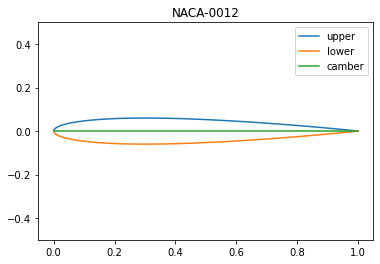

In [7]:
# Visualization
plt.plot(xu,yu, label="upper") # upper surface
plt.plot(xl,yl, label="lower")   # lower surface
plt.plot(0.5*(xu+xl),0.5*(yu+yl), label="camber")   # camber line
plt.legend(loc="upper right")
plt.title(f"NACA-{airfoil_name}")
plt.ylim([-0.5, 0.5])
plt.show()

### Defining Panel Geometry

<img src="figures/fig1.jpg"/>

The geometry of the airfoil will be derived as follows. <br>
Start counting from trailing edge (TE) to leading edge (LE) and from bottom to top. Values of the coordinates will be given in (x,y) pairs. <br>
Let's adjust the orientation of the upper and lower points loaded so they become in accordance to the definition explained above and if there are repeated points in the leading edge. <br>
Let's also start out panels orientation according to the following figure. <br>

<img src="figures/fig2.jpg"/>

$
s = [(XB_{i+1} - XB_{i})^2 + (YB_{i+1} - YB_{i})^2]^{1/2}\\
\phi = atan\big((YB_{i+1} - YB_{i})^2/(XB_{i+1} - XB_{i})^2\big) \\
\delta = \phi + 90^o \\
\beta = \delta - \alpha
$

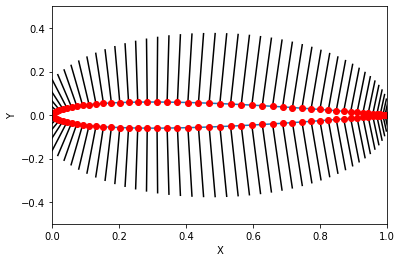

In [8]:
# Clokwise panels
# Geometric quantities of airfoil

# Check if LE is equal to avoid panel with zero length
if xu[0] == xl[0]:
    xu = xu[1:]
    yu = yu[1:]

XB = np.concatenate((np.flip(xl),xu),axis=0)  # Boundary X points
YB = np.concatenate((np.flip(yl),yu),axis=0)  # Boundary Y points

# Control points
XC  = np.zeros(len(XB)-1)
YC  = np.zeros(len(XB)-1)
S   = np.zeros(len(XB)-1)
phi = np.zeros(len(XB)-1)

# Calculate the control points coordinates
for k in range(len(XB)-1):
    XC[k]  = 0.5 * (XB[k] + XB[k+1])        # control points are in the middle of the panel
    YC[k]  = 0.5 * (YB[k] + YB[k+1])
    deltaX = XB[k+1] - XB[k]
    deltaY = YB[k+1] - YB[k]
    S[k]   = np.sqrt(deltaX**2 + deltaY**2) # panel size
    phi[k] = np.arctan2(deltaY,deltaX)      # positive from the x-axis to normal outside panel direction
    if phi[k] < 0:
        phi[k] = phi[k] + 2*np.pi
        
# Panel normal angle
delta = phi + np.pi/2

# Creating beta for every AoA
beta = []
for i in range(len(AoA)):
    beta.append(delta - AoA[i]/180*np.pi)
    for j in range(len(delta)):
        if beta[i][j] > 2*np.pi:
            beta[i][j] -= 2*np.pi  # avoids angle above 360

if airfoil_check:
    plt.plot(XB, YB)
    
    arrow_size = np.zeros(len(XC))
    Xarrow     = np.zeros(len(XC))
    Yarrow     = np.zeros(len(XC))
    
    for i in range(len(XC)):
        arrow_size[i] = S[i]*N/10
        Xarrow[i]     = XC[i] + np.cos(delta[i])*arrow_size[i]
        Yarrow[i]     = YC[i] + np.sin(delta[i])*arrow_size[i]
        plt.plot((XC[i], Xarrow[i]),(YC[i], Yarrow[i]), 'k')
    
    plt.plot(XC, YC, 'ro')
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.xlim([0, 1])
    plt.ylim([-0.5, 0.5])
    plt.show()
    

### Calculating the Normal and Tangential Coefficients (NORM, TANG)

The normal and tangential coefficients are calculated from the integral below. <br><br>
$
K_{ij} = \frac{C_{1}}{2}\big[ln\big(\frac{s_{j}^2 + 2C_{3}s_{j} + C4}{C4}\big)\big] + \frac{C_{2}-C_{1}C_{3}}{C_{5}}\big[atan\big(\frac{s_{j}+C_{3}}{C_{5}}\big) - atan\big(\frac{C_{3}}{C_{5}}\big)\big] \\
N_{ij} = \frac{C_{2}-2C_{1}C_{3}}{2}\big[ln\big(\frac{s_{j}^2+2C_{3}s_{j}+C_{4}}{C_{4}}\big)\big] - \frac{C_{1}(C_{4}-2C_{3}^2)+C_{2}C_{3}}{C_{5}}\big[atan\big(\frac{s_{j}+C_{3}}{C_{5}}\big)-atan\big(\frac{C_{3}}{C_{5}}\big)\big] + C_{1}s_{j}\\
L_{ij} = \frac{C_{6}}{2}\big[ln\big(\frac{s_{j}^2 + 2C_{3}s_{j} + C4}{C4}\big)\big] + \frac{C_{7}-C_{6}C_{3}}
{C_{5}}\big[atan\big(\frac{s_{j}+C_{3}}{C_{5}}\big) - atan\big(\frac{C_{3}}{C_{5}}\big)\big] \\
M_{ij} = \frac{C_{7}-2C_{6}C_{3}}{2}\big[ln\big(\frac{s_{j}^2+2C_{3}s_{j}+C_{4}}{C_{4}}\big)\big] - \frac{C_{6}(C_{4}-2C_{3}^2)+C_{7}C_{3}}{C_{5}}\big[atan\big(\frac{s_{j}+C_{3}}{C_{5}}\big)-atan\big(\frac{C_{3}}{C_{5}}\big)\big] + C_{6}s_{j}\\
$
<br>
where,
<br>
$
C_{1} = -\cos(\phi_{i}-\phi_{j})\\
C_{2} = \cos(\phi_{i})(XC_{i} - XB_{j}) + \sin\phi_{i}(YC_{i}-YB_{j})\\
C_{3} = -\cos(\phi_{j})(XC_{i} - XB_{j}) - \sin\phi_{j}(YC_{i}-YB_{j})\\
C_{4} = (XC_{i}-XB_{j})^2 + (YC_{i}-YB_{j})^2\\
C_{5} = \sqrt{C_{4}-C_{3}^2}\\
C_{6} = \sin(\phi_{j}-\phi_{i})\\
C_{7} = \sin\phi_{i}(XC_{i}-XB_{j})-\cos\phi_{i}(YC_{i}-YB_{j})
$
<br>
and
<br>
$
C_{ij}^{N2} = -\frac{N_{ij}}{s_{j}}\\
C_{ij}^{N1} = -(C_{ij}{N2} + K_{ij})\\
C_{ij}^{T2} = -\frac{M_{ij}}{s_{j}}\\
C_{ij}^{T1} = -(C_{ij}^{T2}+L_{ij})
$

In [9]:
def NORM_TANG_lin(XC, YC, XB, YB, phi, S):
    CN1 = np.zeros((len(XC), len(XC)))
    CN2 = np.zeros((len(XC), len(XC)))
    CT1 = np.zeros((len(XC), len(XC)))
    CT2 = np.zeros((len(XC), len(XC)))
        
    for i in range(len(XC)):
        for j in range(len(XC)):
            
            if j!=i:
                C1 = -np.cos(phi[i] - phi[j])
                C2 = (XC[i] - XB[j]) * np.cos(phi[i]) + (YC[i] - YB[j]) * np.sin(phi[i])
                C3 = -np.cos(phi[j]) * (XC[i] - XB[j]) - np.sin(phi[j]) * (YC[i] - YB[j])
                C4 = (XC[i]-XB[j])**2 + (YC[i]-YB[j])**2
                C5 = np.sqrt(C4 - C3*C3)
                C6 = np.sin(phi[j] - phi[i])
                C7 = (XC[i]-XB[j]) * np.sin(phi[i]) - (YC[i]-YB[j])*np.cos(phi[i])
                
                A = 0.5*(C2-2*C1*C3)  
                B = np.log( (S[j]*S[j]+2*C3*S[j]+C4)/C4 )
                C = (C1*(C4-2*C3*C3) + C2*C3) / C5
                D = np.arctan2((C3+S[j]),C5) - np.arctan2(C3,C5)
                E = 0.5*(C7-2*C6*C3)
                F = (C6*(C4-2*C3*C3) + C7*C3) / C5
                
                CN2[i,j] = -C1 - A*B/S[j] + C*D/S[j]
                CN1[i,j] = -0.5*C1*B - ((C2-C1*C3)/C5)*D - CN2[i,j]
                CT2[i,j] = -C6 - E*B/S[j] + F*D/S[j]
                CT1[i,j] = -0.5*C6*B - ((C7-C6*C3)/C5)*D - CT2[i,j]
            
            else:
                CN2[i,j] = 1
                CN1[i,j] = -1
                CT2[i,j] = 0.5*np.pi
                CT1[i,j] = 0.5*np.pi
    
    return CN1, CN2, CT1, CT2

In [10]:
CN1, CN2, CT1, CT2 = NORM_TANG_lin(XC, YC, XB, YB, phi, S)

### Solving the linear system

The normal velocity on each panel is zero. Therefore, we can create a linear system to solve for the $\gamma$ for each panel. <br>
$
V_{n,i} = U_{\infty}\cos{\beta_{i}} + \sum_{j=1,i \neq j}^{N+1} \big(\frac{\gamma_{j}}{2\pi} C_{ij}^{N1} + \frac{\gamma_{j+1}}{2\pi} C_{ij}^{N2} \big) \\
A\Gamma = B \\
$
Let's define now the A and B matrices: {br}
Recall that in order to define a physical solution, the Kutta condition must be satisfied. <br>
$
\gamma(TE) = 0 \\
\gamma_{1} = -\gamma_{N}
$

In [11]:
# Kutta condition - gamma[0] + gamma[N-1] = 0
# A matrix
A_MATRIX_N = np.zeros((len(CN1)+1,len(CN1)+1))
A_MATRIX_T = np.zeros((len(CN1)+1,len(CN1)+1))

for k in range(len(CN1)):
    A_MATRIX_N[k,0]  = CN1[k,0]
    A_MATRIX_N[k,-1] = CN2[k,-1]
    A_MATRIX_T[k,0]  = CT1[k,0]
    A_MATRIX_T[k,-1] = CT2[k,-1]
    for l in range(1,len(CN1)):
        A_MATRIX_N[k,l] = CN1[k,l] + CN2[k,l-1]
        A_MATRIX_T[k,l] = CT1[k,l] + CT2[k,l-1]

A_MATRIX_N[-1,:] = np.concatenate((np.array([1]),np.zeros(len(CN1)-1),np.array([1])))
A_MATRIX_T[-1,:] = np.concatenate((np.array([1]),np.zeros(len(CN1)-1),np.array([1])))

And to calculate lift, two options: <br> <br>
1 - Kutta-Jokovsky theorem <br>
$
L = \rho U_{\infty} \Gamma \\
C_{l} = \frac{L}{\frac{1}{2} \rho U_{\infty}^{2}c} \\
$
2 - Cp distribution
$
V_{t,i} = U_{\infty} \sin{\beta_{i}} + \sum_{j=1, i \neq j}^{N} \gamma_{j}' C_{ij}^{T1} + \gamma_{j+1}'C_{ij}^{T2} \\
C_{p} = 1 - \big(\frac{V_{t,i}}{U_{\infty}} \big)^{2}
$
<br>
where,
<br>
$
\gamma' = \frac{\gamma}{2\pi}
$


In [12]:
B_MATRIX = []
GAMMA    = []
Vt       = []
Cp       = []

for i in range(len(AoA)):
    container = np.zeros(len(XB))
    B_MATRIX.append(container)
    for k in range(len(XB)):
        if k == len(XB)-1:
            B_MATRIX[i][k] = 0    # Kutta-condition
        else:
            B_MATRIX[i][k] = -U_inf*np.cos(beta[i][k])        # Right hand side
    
    GAMMA.append(np.linalg.lstsq(A_MATRIX_N,B_MATRIX[i],rcond=None)[0])  # Solving the linear system of eq
    # Creating two containers so that one does not get overwritten by the other
    container1 = np.zeros(len(CN1))
    container2 = np.zeros(len(CN1))
    Vt.append(container1)
    Cp.append(container2)
    for k in range(len(CN1)):
        Vt[i][k] = U_inf*np.sin(beta[i][k])
        for l in range(len(CN1)+1):
            Vt[i][k] = Vt[i][k] + GAMMA[i][l] * A_MATRIX_T[k,l]
            Cp[i][k] = 1 - (Vt[i][k]/U_inf)**2

### Lift, Drag, and Moment Calculations

$
C_{N} = \frac{1}{c} \int_{LE}^{TE} (C_{p,l} - C_{p,u}) \cos \theta ds_{j} \\
C_{A} = \frac{1}{c} \int_{LE}^{TE} (C_{p,l} - C_{p,u}) \sin \theta ds_{j} \\
C_{M_{c/4}} = \frac{1}{c} \big[ -\int_{LE}^{TE} (C_{p,l} - C_{p,u}( \cos \theta (x - 0.25c) ds_{j} + \int_{LE}^{TE} (C_{p,l} - C_{p,u}) \sin \theta y ds_{j} \big] \\
C_{N} = \frac{1}{c} \big[\sum_{j=1}^{N} -C_{p,j} s_{j} \sin \delta_{j}  \big] \\
C_{A} = \frac{1}{c} \big[\sum_{j=1}^{N} -C_{p,j} s_{j} \cos \delta_{j}  \big] \\
C_{M_{c/4}} = \frac{1}{c} \big[ -\sum_{j=1}^{N} -C_{p,j} s_{j} (x_{j} - 0.25c) \sin \delta_{j} + \sum_{j=1}^{N} -C_{p,j} s_{j} 
y_{j} \cos \delta_{j} \big] \\
$

In [13]:
# Compute lift, drag, and moment

CN   = []
CA   = []
CL   = []
CD   = []
CM   = []
CL_k = []

for i in range(len(AoA)):
    CN.append(-Cp[i] * S * np.sin(delta))
    CA.append(-Cp[i] * S * np.cos(delta))
    
    CL_i = np.sum(CN[i] * np.cos(np.deg2rad(AoA[i]))) - np.sum(CA[i] * np.sin(np.deg2rad(AoA[i])))
    CD_i = np.sum(CN[i] * np.sin(np.deg2rad(AoA[i]))) + np.sum(CA[i] * np.cos(np.deg2rad(AoA[i])))
    CM_i = -np.sum(-Cp[i] * (XC - 0.25) * S * np.sin(delta)) + np.sum(-Cp[i] * YC * S * np.cos(delta))
    CL.append(CL_i)
    CD.append(CD_i)
    CM.append(CM_i)

In [14]:
# Reporting CL, CD, CM
print(f'CL = {CL}')
print(f'CD = {CD}')
print(f'CM = {CM}')

CL = [7.37029794833921e-15, 0.11958707226860885, 0.2391277631463306, 0.3585757326537693, 0.4778847235470517, 0.5970086024673809, 0.7159014008292708, 0.8345173553615393, 0.9528109482159002, 1.0707369465593282]
CD = [0.0022464042064654897, 0.0023411593103066066, 0.0026251351035769073, 0.003097463834144807, 0.003756701921677791, 0.004600833959772253, 0.005627278303545494, 0.006832894227363398, 0.008213990633051574, 0.009766336284699806]
CM = [-1.6536831876394875e-15, -0.0015649828453174236, -0.003128059000103581, -0.004687324096838569, -0.0062408784111886145, -0.0077868291765281344, -0.009323292889985069, -0.01084839760719916, -0.012360285222995707, -0.013857113735204329]


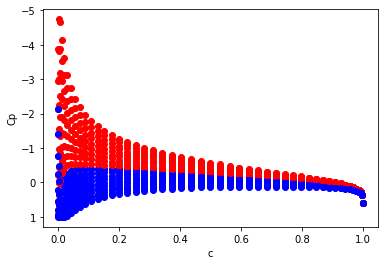

In [15]:
# Plotting aerodynamic performances
N_panel = len(XC)
for i in range(len(AoA)):
    plt.plot(XC[int(N_panel/2):],Cp[i][int(N_panel/2):],'ro')
    plt.plot(XC[0:int(N_panel/2)],Cp[i][0:int(N_panel/2)],'bo')
plt.gca().invert_yaxis()
plt.xlabel('c')
plt.ylabel('Cp')
plt.show()

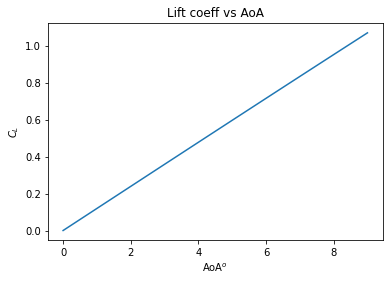

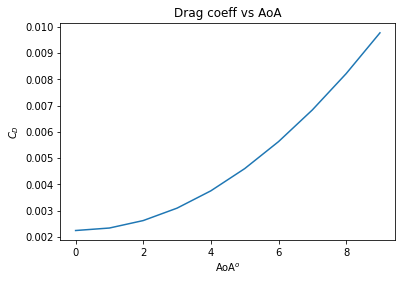

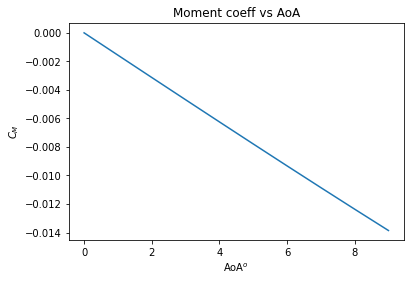

In [16]:
# Plot aero performance over alpha
if len(AoA)>1:
    plt.plot(AoA, CL)
    plt.ylabel('$C_{L}$')
    plt.xlabel('AoA$^o$')
    plt.title('Lift coeff vs AoA')
    plt.show();
    plt.plot(AoA, CD)
    plt.ylabel('$C_{D}$')
    plt.xlabel('AoA$^o$')
    plt.title('Drag coeff vs AoA')
    plt.show();
    plt.plot(AoA, CM)
    plt.ylabel('$C_{M}$')
    plt.xlabel('AoA$^o$')
    plt.title('Moment coeff vs AoA')
    plt.show();

### Streamlines

<img src='figures/fig3.jpg' /> 

In [17]:
def StreamLine(XP, YP, XB, YB, phi, S):
    
    Cx1 = np.zeros((len(XB)-1, len(XB)-1))
    Cx2 = np.zeros((len(XB)-1, len(XB)-1))
    Cy1 = np.zeros((len(XB)-1, len(XB)-1))
    Cy2 = np.zeros((len(XB)-1, len(XB)-1))
    
    for j in range(len(XB)-1):
        C1 = np.sin(phi[j])
        C2 = -(YP - YB[j])
        C3 = -np.cos(phi[j]) * (XP - XB[j]) - np.sin(phi[j]) * (YP - YB[j])
        C4 = (XP - XB[j])**2 + (YP - YB[j])**2
        C5 = np.sqrt(C4 - C3*C3)
        C6 = -np.cos(phi[j])
        C7 = XP - XB[j]
        
        A  = 0.5 * (C2 - 2*C1*C3)
        B  = np.log((S[j]**2 + 2*C3*S[j] + C4)/C4)
        C  = (C1*(C4-2*C3**2) + C2*C3)/C5
        D  = np.arctan2((C3+S[j]),C5) - np.arctan2(C3,C5)
        E  = 0.5 * (C7 - 2*C6*C3)
        F  = (C6 * (C4 - 2*C3**2) + C7*C3)/C5
        
        Cx2[j,0] = -C1 - A*B/S[j] + C*D/S[j]
        Cx1[j,0] = -0.5*C1*B - ((C2-C1*C3)/C5)*D - Cx2[j,0]
        Cy2[j,0] = -C6 - E*B/S[j] + F*D/S[j]
        Cy1[j,0] = -0.5*C6*B - ((C7-C6*C3)/C5)*D - Cy2[j,0]
    
    return Cx1, Cx2, Cy1, Cy2

In [18]:
# Streamlines

if plot_stream:
    # Grid parameters
    nGridX = 70            # X-grid for streamlines and contours
    nGridY = 70            # Y-grid for streamlines and contours
    xVals  = [-0.5, 1.5]   # X-grid boundary
    yVals  = [-0.5, 0.5]   # Y-grid boundary

    # Streamline parameters
    stepsize = 0.01                                                          # step size for streamline propagation
    maxVert  = nGridX * nGridY * 100                                         # maximum vertices
    slPct    = 40                                                            # percentage of streamlines of the grid
    Ysl      = np.linspace(yVals[0],yVals[1],int(slPct/100*nGridY))          # create array of Y streamline starting points

    # Generate the grid points
    Xgrid    = np.linspace(xVals[0],xVals[1],nGridX)
    Ygrid    = np.linspace(yVals[0],yVals[1],nGridY)
    XX, YY   = np.meshgrid(Xgrid, Ygrid)

    # Initialize velocities
    Vx = np.zeros((nGridX, nGridY))
    Vy = np.zeros((nGridX, nGridY))

    # Solver for grid point X and Y velocities
    for m in range(nGridX):
        print(f"Solving grid-pair = {m}")
        for n in range(nGridY):
            XP = XX[m, n]                                              # current iteration's X grid point
            YP = YY[m, n]                                              # current iteration's Y grid point
            Cx1, Cx2, Cy1, Cy2 = StreamLine(XP, YP, XB, YB, phi, S)    # compute Nx and Ny geometric integrals

            # A matrix
            Nx = np.zeros((len(Cx1)+1, len(Cx1)+1))
            Ny = np.zeros((len(Cx1)+1, len(Cx1)+1))

            for k in range(len(Cx1)):
                Nx[k,0]  = Cx1[k,0]
                Nx[k,-1] = Cx2[k,-1]
                Ny[k,0]  = Cy1[k,0]
                Ny[k,-1] = Cy2[k,-1]
                for l in range(1,len(Cx1)):
                    Nx[k,l] = Cx1[k,l] + Cx2[k,l-1]
                    Ny[k,l] = Cy1[k,l] + Cy2[k,l-1]

            Nx[len(Cx1),:] = np.concatenate((np.array([0]),np.zeros(len(CN1)-1),np.array([0])))
            Ny[len(Cx1),:] = np.concatenate((np.array([0]),np.zeros(len(CN1)-1),np.array([0])))
            
            # Check whether the point is inside the airfoil
            p         = path.Path(np.concatenate((XB,YB),axis=1))
            is_inside = p.contains_points([[XP, YP]])[0]
            
            if is_inside:
                Vx[m, n] = 0.0
                Vy[m, n] = 0.0
            else:
                Vx[m, n] = U_inf * np.cos(np.deg2rad(AoA[5])) + np.sum(GAMMA[0] * Nx)  # compute X-velocity at AoA = 5
                Vy[m, n] = U_inf * np.sin(np.deg2rad(AoA[5])) + np.sum(GAMMA[0] * Ny)  # compute Y-velocity at AoA = 5
    
    # Compute grid point velocity magnitude and pressure coefficient
    Vxy  = np.sqrt(Vx*Vx + Vy*Vy)
    CpXY = 1 - (Vxy/U_inf)**2

Solving grid-pair = 0
Solving grid-pair = 1
Solving grid-pair = 2
Solving grid-pair = 3
Solving grid-pair = 4
Solving grid-pair = 5
Solving grid-pair = 6
Solving grid-pair = 7
Solving grid-pair = 8
Solving grid-pair = 9
Solving grid-pair = 10
Solving grid-pair = 11
Solving grid-pair = 12
Solving grid-pair = 13
Solving grid-pair = 14
Solving grid-pair = 15
Solving grid-pair = 16
Solving grid-pair = 17
Solving grid-pair = 18
Solving grid-pair = 19
Solving grid-pair = 20
Solving grid-pair = 21
Solving grid-pair = 22
Solving grid-pair = 23
Solving grid-pair = 24
Solving grid-pair = 25
Solving grid-pair = 26
Solving grid-pair = 27
Solving grid-pair = 28
Solving grid-pair = 29
Solving grid-pair = 30
Solving grid-pair = 31
Solving grid-pair = 32
Solving grid-pair = 33
Solving grid-pair = 34
Solving grid-pair = 35
Solving grid-pair = 36
Solving grid-pair = 37
Solving grid-pair = 38
Solving grid-pair = 39
Solving grid-pair = 40
Solving grid-pair = 41
Solving grid-pair = 42
Solving grid-pair = 4

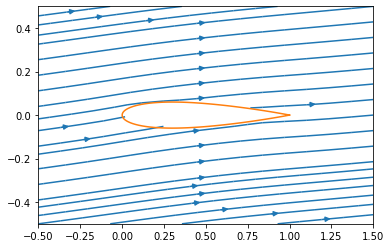

In [19]:
# Plot the streamlines

# This is not correct
# because Vx and Vy are not zero on the airfoil surface
# need to implement matlab "inpolygon" function to include the boundary
# because the matplotlib.path.contains_points() does not include the boundary 

startPoints = []
for i in range(len(Ysl)):
    startPoints.append([xVals[0],Ysl[i]])
plt.streamplot(XX,YY,Vx,Vy,density=0.5,broken_streamlines=False)
plt.plot(XB, YB)
plt.xlim(xVals)
plt.ylim(yVals)
plt.show()

### Aerodynamic Center of the Airfoil

Usually located at $c/4$. The aerodynamic center is the position along the airfoil where the moment does not vary with angle of attack: <br> <br>
$
\frac{dC_{M}}{d \alpha} = 0 \\
$

In [20]:
def dCM_da_error(xAC):
    
    target = 0.0 # DCM_da = 0 at the aero center
   
    CM = np.zeros(len(AoA))
    for i in range(len(AoA)):
        CM[i] = -np.sum(-Cp[i]*(XC-xAC)*S*np.sin(delta)) + np.sum(-Cp[i]*YC*S*np.cos(delta))
    
    #Linear Regression
    reg = linear_model.LinearRegression()
    reg.fit(np.array(AoA).reshape(-1,1),np.array(CM).reshape(-1,1))
    dCM_da = reg.coef_
    
    return abs(dCM_da[0,0] - target)

In [21]:
# Optimization to find xAC (search AoA = [0.1,0.7])

from scipy.optimize import fminbound

xAC = fminbound(dCM_da_error, 0.1, 0.7)

print(f'aerodynamic center is located at x={xAC}')
print(f'dCM_da_error = {dCM_da_error(xAC)}')

aerodynamic center is located at x=0.2630862339647211
dCM_da_error = 2.540209300962805e-07
